# Create initial condition fields for Mn

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import datetime
from mpl_toolkits.basemap import Basemap, cm
import cmocean
import glob
from math import isclose

%matplotlib inline

### Load Marco Van Hulten's model output:

In [2]:
folder = '/ocean/brogalla/GEOTRACES/data/van_hulten/'
file = 'Fmang-16B05-LD40_Bio_1y_ptrc_T_P80.nc' #Fmang-16B05-LD40_Bio_1y_diad_T_P80.nc 

In [3]:
a = nc.Dataset(folder+file)

mn_dis = a.variables['dMn'] # time, deptht, y, x
mn_oxi = a.variables['oMn']
depths = a.variables['deptht']
time = a.variables['time']
lats = a.variables['nav_lat']
lons = a.variables['nav_lon']

In [4]:
mask  = nc.Dataset('/ocean/brogalla/GEOTRACES/ariane_runs/ANHA12_Ariane_mesh.nc')
tmask = np.array(mask.variables['tmask'])
tmask = tmask[0,0,:,:]
cond = (tmask > 0.1) 
Z_masked = np.ma.masked_where(cond, tmask) 

In [5]:
mesh  = nc.Dataset('/ocean/brogalla/GEOTRACES/analysis-birgit/notebooks/ANHA12/ANHA12_mesh1.nc')
mlons = np.array(mesh.variables['nav_lon'])
mlats = np.array(mesh.variables['nav_lat'])
z_levels = np.array(mesh.variables['nav_lev'])

FileNotFoundError: [Errno 2] No such file or directory: b'/ocean/brogalla/GEOTRACES/analysis-birgit/notebooks/ANHA12/ANHA12_mesh1.nc'

In [6]:
def plot_variable(variable, lons, lats, depth_level=0):

    fig,ax = plt.subplots(figsize=(10,10))
    proj=Basemap(projection='eqdc',lat_0 = 77, lon_0 = -98, resolution='i', width=2.25e6, height=2.25e6)
    proj.drawcoastlines(linestyle='-', color=[0.35, 0.35, 0.35], linewidth=1, zorder=3)
    proj.drawparallels(np.arange(int(65),int(90),2),labels=[1,0,0,0], linewidth=0.0)
    proj.drawmeridians(np.arange(int(-140),int(-30),5),labels=[0,0,0,1], linewidth=0.0)

    lats = np.array(lats)
    lons = np.array(lons)
    x, y = proj(lons, lats)
    
    var_name = variable.name
    variable = np.array(variable)
    x1 = x[:,:]
    y1 = y[:,:]
    if depth_level == -1:
        z1 = variable[0][:,:]
    else:
        z1 = variable[0][depth_level,:,:]
        
    x2, y2 = proj(mlons, mlats)
    z2 = Z_masked
    
    cmap1 =cmocean.cm.gray_r
    
    CS1 = proj.pcolor(x1, y1, z1, cmap=cmocean.cm.deep)
#     proj.pcolor(x2,y2,z2, cmap=cmap1)
    proj.plot(x1[137,64], y1[137,64], '*', markersize=10, zorder=5)
    
    cbaxes = fig.add_axes([0.975, 0.15, 0.02, 0.7]) 
    CBar = plt.colorbar(CS1, ax=ax, cax=cbaxes) 
    a = CBar.set_label(var_name + ' [kmol / m3]', fontsize=12)
    CBar.ax.tick_params(axis='y', length=0)
#     fig.savefig(var_name +'_ini.png',bbox_inches='tight')
    return

In [7]:
for i in range(0,len(lons[:,0])):
    for j in range(0,len(lons[0,:])):
        if isclose(lons[i,j],-130,abs_tol=1) & isclose(lats[i,j],77,abs_tol=1):
            print(i, j)

137 64
138 63


NameError: name 'mlons' is not defined

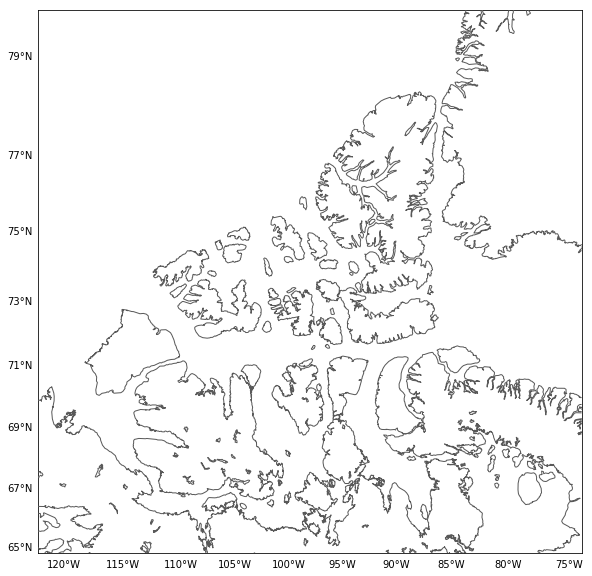

In [8]:
plot_variable(mn_dis, lons, lats)

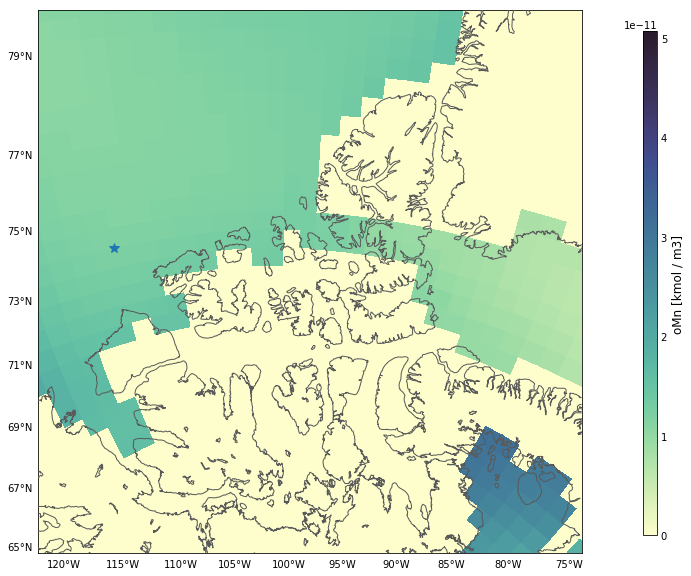

In [36]:
plot_variable(mn_oxi, lons, lats)

Profiles:

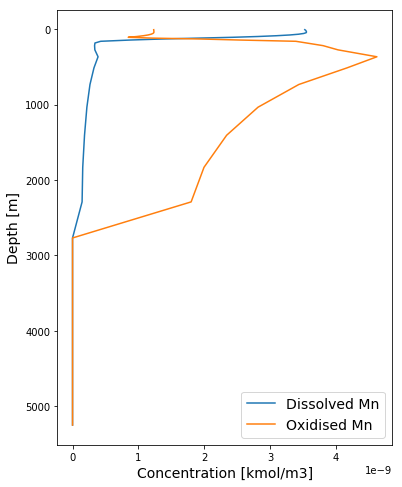

In [46]:
fig, ax = plt.subplots(1,1, figsize=(6,8))
ax.invert_yaxis()

x=137
y=64
ax.plot(mn_dis[0,:,x,y], depths, label='Dissolved Mn')
ax.plot(mn_oxi[0,:,x,y]*10**2, depths, label='Oxidised Mn')

ax.set_ylabel('Depth [m]', fontsize=14)
ax.set_xlabel('Concentration [kmol/m3]', fontsize=14)

ax.legend(fontsize=14)

### Load ANHA12 fields to interpolate to:

In [8]:
mesh = '/data/brogalla/ANHA12/2015/ANHA12-EXH006_y2011m06d24_gridT.nc'
m = nc.Dataset(mesh)

In [9]:
mdepth = m.variables['deptht']
mlons = m.variables['nav_lon']
mlats = m.variables['nav_lat']

In [10]:
mdepth = np.array(mdepth)
mlons = np.array(mlons)
mlats = np.array(mlats)

### Interpolate from outer boundaries:

First interpolate with depth: depths --> mdepth

In [11]:
print('Original size: ' + str(depths.shape))
print('New size: ' + str(mdepth.shape))

Original size: (31,)
New size: (50,)


In [12]:
mn_oxi = np.array(mn_oxi)
mn_dis = np.array(mn_dis)

In [13]:
mn_dis.shape

(1, 31, 149, 182)

In [14]:
search_dis = mn_dis[0,:,:,:]
for i in range(0,31):
    for j in range(0,149):
        for k in range(0,182):
            if search_dis[i,j,k] > 1.0e1:
                print(i,j,k)

30 93 34


In [15]:
mn_oxi[mn_oxi==0] = 1.0e-11
mn_dis[mn_dis==0] = 1e-9
mn_dis[0,30,93,34] = 1e-9

In [56]:
def interp_depths(var, mdepth,fill):
    # constant extrapolation for values outside of the range
    from scipy import interpolate
    
    interp_var = np.empty((50, 149, 182))
    x = depths
    
    for i in range(0,149):
        for j in range(0,182):
            # interpolate over depths        
            y = var[0,:,i,j]
            f = interpolate.interp1d(x, y, fill_value = fill)
            interp_var[:,i,j] = f(mdepth)
    return interp_var

In [57]:
i_mn_oxi = interp_depths(mn_oxi, mdepth, fill='extrapolate')
i_mn_dis = interp_depths(mn_dis, mdepth, fill='extrapolate')
i_mn_oxi = np.array(i_mn_oxi)
i_mn_dis = np.array(i_mn_dis)

In [58]:
i_mn_oxi[i_mn_oxi<0] = 1.0e-11
i_mn_dis[i_mn_dis<0] = 0.1e-8

Then spatially: lons --> mlons, lats --> mlats

In [59]:
lons = np.array(lons)
lats = np.array(lats)
mlons = np.array(mlons)
mlats = np.array(mlats)

In [60]:
print(np.amin(i_mn_dis))
print(np.amax(i_mn_dis))
print(np.average(i_mn_dis))

3.3017605576696196e-12
5.1750308927012156e-08
7.66241796144628e-10


In [62]:
print(np.amin(i_mn_oxi))
print(np.amax(i_mn_oxi))
print(np.average(i_mn_oxi))

1.1458856528034043e-14
4.616454774009071e-09
1.6913911594421247e-11


In [63]:
print(i_mn_oxi.shape)

(50, 149, 182)


In [42]:
# i_lons = lons.flatten()
# i_lats = lats.flatten()
# i_var = i_mn_oxi[0,:,:].flatten()

In [43]:
# ir_mn_oxi = np.array([i[~np.isnan(i)] for i in i_mn_oxi])
# ir_mn_dis = np.array([i[~np.isnan(i)] for i in i_mn_dis])
# ir_lons = np.array(i_lons[~np.isnan(i_var)])
# ir_lats = np.array(i_lats[~np.isnan(i_var)])

In [64]:
def interp_np(nav_lon, nav_lat, var_in, lon_ANHA12, lat_ANHA12):
    ''' Interpolate Mn model output from Marco to ANHA12 grid.
        The function is based on the bilinear interpolation in scipy, griddata 
        =======================================================================
            nav_lon, nav_lat        : Mn model lons/lats
            lon_ANHA12, lat_ANHA12  : ANHA12 defined lons/lats
            var_in                  : 2-D Mn model variable
    '''
    from scipy.interpolate import griddata

    LatLonPair = (nav_lon.flatten(), nav_lat.flatten())
    var_out = griddata(LatLonPair, var_in.flatten(), (lon_ANHA12, lat_ANHA12), method='linear')
    # Take nearest neighbour interpolation to fill nans
    var_fill = griddata(LatLonPair, var_in.flatten(), (lon_ANHA12, lat_ANHA12), method='nearest')
    var_out[np.isnan(var_out)] = var_fill[np.isnan(var_out)]
    return var_out

In [65]:
ini_mn_oxi = np.empty((50, 2400, 1632))
ini_mn_dis = np.empty((50, 2400, 1632))

for i in range(0,50):
    ini_mn_oxi[i,:,:] = interp_np(lons, lats, i_mn_oxi[i,:,:], mlons, mlats)
    ini_mn_dis[i,:,:] = interp_np(lons, lats, i_mn_dis[i,:,:], mlons, mlats)

In [66]:
i_mn_oxi[0,:,:].shape

(149, 182)

In [67]:
# Check whether any of the values are NaN:
print(np.count_nonzero(np.isnan(ini_mn_oxi)))
print(np.count_nonzero(np.isnan(ini_mn_dis)))

0
0


In [87]:
def plot_ini(variable, lons, lats, label, depth_level=0):
    # plot background map of land:
    fig,ax = plt.subplots(figsize=(10,10))
    proj=Basemap(projection='eqdc',lat_0 = 77, lon_0 = -98, resolution='i', width=2.25e6, height=2.25e6)
    proj.drawcoastlines(linestyle='-', color=[0.35, 0.35, 0.35], linewidth=1, zorder=3)
    #proj.fillcontinents(color=[0.75, 0.75, 0.75], lake_color=None, zorder=2) 
    proj.drawparallels(np.arange(int(65),int(90),2),labels=[1,0,0,0], linewidth=0.0)
    proj.drawmeridians(np.arange(int(-140),int(-30),5),labels=[0,0,0,1], linewidth=0.0)

    lats = np.array(lats)
    lons = np.array(lons)
    x, y = proj(lons, lats)
    
    variable = np.array(variable)
    x1 = x[:,:]
    y1 = y[:,:]
    z1 = variable[depth_level,:,:]
    
    p2_lon = mlons[172+910,585+200]
    p2_lat = mlats[172+910,585+200]
    
    x2, y2 = proj(p2_lon, p2_lat)
    
    proj.scatter(x2, y2, marker='*',s=130,zorder=3, c='r')

    CS1 = proj.pcolor(x1, y1, z1, cmap=cmocean.cm.deep)
    
    x2, y2 = proj(mlons, mlats)
    z2 = Z_masked
    cmap1 =cmocean.cm.gray_r
    proj.pcolor(x2,y2,z2, cmap=cmap1)
    
    cbaxes = fig.add_axes([0.975, 0.15, 0.02, 0.7]) 
    CBar = plt.colorbar(CS1, ax=ax, cax=cbaxes) 
    a = CBar.set_label(label+' [kmol / m3]', fontsize=12)
    CBar.ax.tick_params(axis='y', length=0)
    
#     fig.savefig(label+'_ini_field.png', bbox_inches='tight')
    return

#### linear interpolation w. constant values filled in:

In [88]:
print(np.amax(ini_mn_oxi))
print(np.amax(ini_mn_dis))

5.44342662759666e-10
1.4609547673932394e-08


In [89]:
print(np.amin(ini_mn_oxi), np.amin(ini_mn_dis))
print(ini_mn_oxi.shape, ini_mn_dis.shape)

7.622660444609504e-14 2.1909505833591482e-11
(50, 2400, 1632) (50, 2400, 1632)


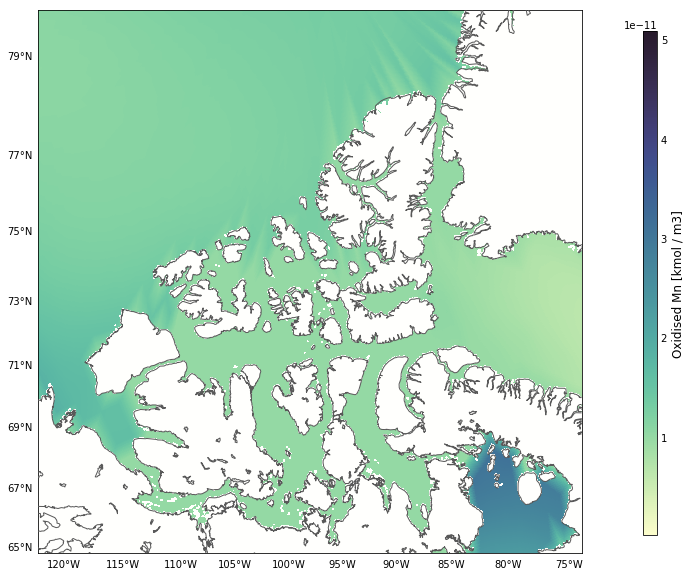

In [90]:
plot_ini(ini_mn_oxi, mlons, mlats, 'Oxidised Mn')

In [52]:
ini_mn_oxi.shape

(50, 2400, 1632)

In [74]:
for i in range(0,len(mlons[:,0])):
    for j in range(0,len(mlons[0,:])):
        if isclose(mlons[i,j],-130,abs_tol=0.1) & isclose(mlats[i,j],77,abs_tol=0.1):
            print(i, j)

1973 578
1973 579
1974 576
1974 577
1974 578
1975 575
1975 576
1976 575


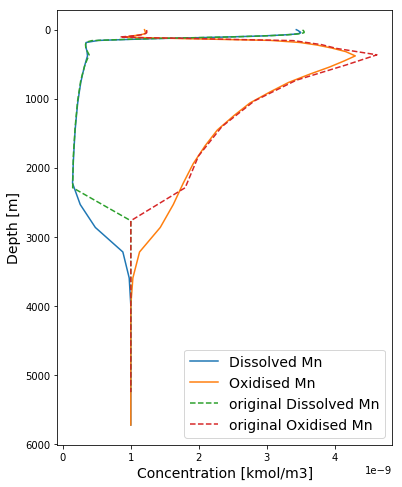

In [78]:
fig, ax = plt.subplots(1,1, figsize=(6,8))
ax.invert_yaxis()

x=1973
y=578
ax.plot(ini_mn_dis[:,x,y], z_levels, label='Dissolved Mn')
ax.plot(ini_mn_oxi[:,x,y]*10**2, z_levels, label='Oxidised Mn')

xo=137
yo=64
ax.plot(mn_dis[0,:,xo,yo], depths, '--', label='original Dissolved Mn')
ax.plot(mn_oxi[0,:,xo,yo]*10**2, depths, '--', label='original Oxidised Mn')

ax.set_ylabel('Depth [m]', fontsize=14)
ax.set_xlabel('Concentration [kmol/m3]', fontsize=14)

ax.legend(fontsize=14)

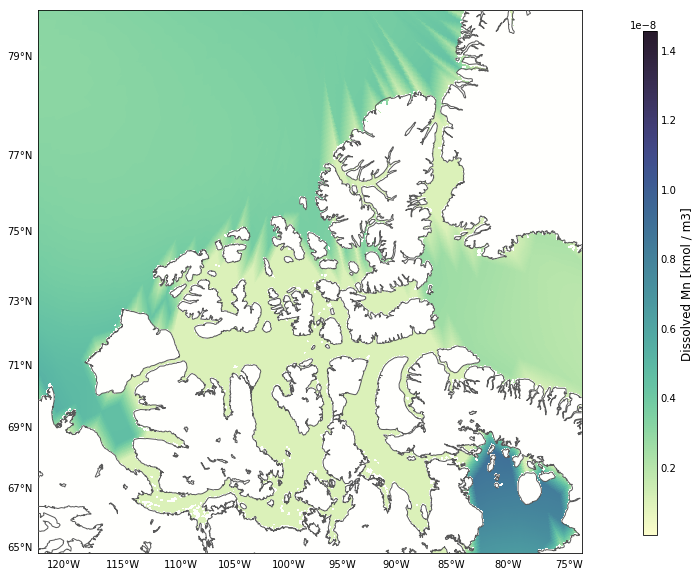

In [91]:
plot_ini(ini_mn_dis, mlons, mlats, 'Dissolved Mn')

### Write NetCDF IC file:

In [16]:
c = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12-EXH006_y2015m01d05_gridT.nc','r')

# Load structure from sample dataset:
lat = c.variables['nav_lat']
lon = c.variables['nav_lon']
depths = c.variables['deptht']
time = c.variables['time_counter']
BX = c.dimensions['x']
BY = c.dimensions['y']
BT = c.dimensions['time_counter']
depth_out = depths

In [18]:
print(depths.shape)
print(lat.shape)
print(lon.shape)
print(BX)
print(BY)
# omn_var_ini = np.array(ini_mn_oxi)
# dmn_var_ini = np.array(ini_mn_dis)

(50,)
(2400, 1632)
(2400, 1632)
<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 1632

<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 2400



In [30]:
# Setup the new NetCDF file:
# ncd = nc.Dataset('/ocean/brogalla/GEOTRACES/data/Mn_ini_20190802.nc', 'w', zlib=True)
ncd = nc.Dataset('/ocean/brogalla/GEOTRACES/data/zeros.nc', 'w', zlib=True)

ncd.createDimension('x',len(BX))
ncd.createDimension('y',len(BY))
ncd.createDimension('deptht',size=len(depth_out))
ncd.createDimension('time_counter',None)

<class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time_counter', size = 0

In [31]:
# # variables
# dmn_var = ncd.createVariable('dMn', 'float64', ('time_counter','deptht','y','x'))
# dmn_var.units = 'kmol/m3'
# dmn_var.long_name = 'Dissolved Mn concentration'  
# dmn_var.coordinates = 'nav_lon nav_lat deptht time_counter'
# dmn_var[0,:,:,:] = dmn_var_ini

# omn_var = ncd.createVariable('oMn', 'float64', ('time_counter','deptht','y','x'))
# omn_var.units = 'kmol/m3'
# omn_var.long_name = 'Oxidised Mn concentration'  
# omn_var.coordinates = 'nav_lon nav_lat deptht time_counter'
# omn_var[0,:,:,:] = omn_var_ini

dmn_var = ncd.createVariable('zeros', 'float64', ('time_counter','deptht','y','x'))
dmn_var.units = 'none'
dmn_var.long_name = 'zeros'  
dmn_var.coordinates = 'nav_lon nav_lat deptht time_counter'
dmn_var[0,:,:,:] = np.zeros((50,2400,1632))

In [32]:
dmn_var

<class 'netCDF4._netCDF4.Variable'>
float64 zeros(time_counter, deptht, y, x)
    units: none
    long_name: zeros
    coordinates: nav_lon nav_lat deptht time_counter
unlimited dimensions: time_counter
current shape = (1, 50, 2400, 1632)
filling on, default _FillValue of 9.969209968386869e+36 used

In [34]:
ncd.close()